# 06 — Baseline Models

**Goal:** Establish a linear baseline per position group that advanced models must beat.

**Inputs:** `../data/processed/X_train/test_{pos}.csv` · `y_train/test_{pos}.csv` · `final_features.json`

**Outputs:** `../models/baseline_models.pkl` · `../data/processed/baseline_results.json` · `../figures/06_*.png`

**Next:** `07_advanced_models.ipynb`

---
**Models compared:**
- **Linear Regression** — plain OLS, most interpretable
- **Ridge (RidgeCV)** — L2 regularisation; handles correlated features better (`log_minutes` ↔ `log_appearances`)
- **Lasso (LassoCV)** — L1 regularisation; performs implicit feature selection

The best baseline per position is saved to `baseline_models.pkl` as the threshold for notebook 07.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import pickle
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

PROC_PATH    = '../data/processed/'
SPLITS_PATH  = '../data/processed/splits/'
MODELS_PATH  = '../models/'
FIGURES_PATH = '../figures/'
os.makedirs(MODELS_PATH,  exist_ok=True)
os.makedirs(FIGURES_PATH, exist_ok=True)

POSITIONS = ['GK', 'DEF', 'MID', 'ATT']

print('Imports OK')

Imports OK


## 1. Load Preprocessed Splits

In [2]:
with open(PROC_PATH + 'final_features.json') as f:
    FINAL_FEATURES = json.load(f)

data = {}
for pos in POSITIONS:
    p = pos.lower()
    X_train = pd.read_csv(SPLITS_PATH + f'X_train_{p}.csv', index_col=0)
    X_test  = pd.read_csv(SPLITS_PATH + f'X_test_{p}.csv',  index_col=0)
    y_train = pd.read_csv(SPLITS_PATH + f'y_train_{p}.csv', index_col=0).squeeze()
    y_test  = pd.read_csv(SPLITS_PATH + f'y_test_{p}.csv',  index_col=0).squeeze()
    data[pos] = (X_train, X_test, y_train, y_test)
    print(f'  {pos}: train={len(X_train):,}  test={len(X_test):,}  features={X_train.shape[1]}')

  GK: train=2,650  test=663  features=18
  DEF: train=7,893  test=1,974  features=19
  MID: train=7,180  test=1,796  features=18
  ATT: train=6,843  test=1,711  features=19


## 2. Evaluation Helper

In [3]:
def evaluate(y_true, y_pred):
    """Return metrics in log-scale and EUR-scale."""
    r2   = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    # Back to EUR for interpretability (median error in euros)
    rmse_eur_M = np.sqrt(mean_squared_error(
        np.expm1(y_true), np.expm1(y_pred)
    )) / 1e6
    return {'R2': round(r2, 4), 'RMSE': round(rmse, 4),
            'MAE': round(mae, 4), 'RMSE_EUR_M': round(rmse_eur_M, 3)}

print('evaluate() defined — returns R², RMSE (log), MAE (log), RMSE (€M)')

evaluate() defined — returns R², RMSE (log), MAE (log), RMSE (€M)


## 3. Fit Baseline Models

Three models × four positions. Ridge and Lasso use cross-validated alpha selection (5-fold on train).

In [5]:
ALPHAS = [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]

results  = {}   # {pos: {model_name: {train: metrics, test: metrics}}}
models   = {}   # {pos: {model_name: fitted_model}}

for pos in POSITIONS:
    X_train, X_test, y_train, y_test = data[pos]
    results[pos] = {}
    models[pos]  = {}

    model_defs = [
        ('LinearRegression', LinearRegression()),
        ('Ridge',            RidgeCV(alphas=ALPHAS, cv=5)),
        ('Lasso',            LassoCV(n_alphas=50, cv=5, max_iter=5000, random_state=42)),
    ]

    print(f'\n{pos}:')
    for name, model in model_defs:
        model.fit(X_train, y_train)

        train_metrics = evaluate(y_train, model.predict(X_train))
        test_metrics  = evaluate(y_test,  model.predict(X_test))

        results[pos][name] = {'train': train_metrics, 'test': test_metrics}
        models[pos][name]  = model

        alpha_str = ''
        if hasattr(model, 'alpha_'):  alpha_str = f'  α={model.alpha_:.4g}'

        print(f'  {name:<20}  train R²={train_metrics["R2"]:.3f}  '
              f'test R²={test_metrics["R2"]:.3f}  '
              f'RMSE={test_metrics["RMSE"]:.3f}  '
              f'RMSE_EUR={test_metrics["RMSE_EUR_M"]:.2f}M{alpha_str}')


GK:
  LinearRegression      train R²=0.762  test R²=0.713  RMSE=0.746  RMSE_EUR=2.34M
  Ridge                 train R²=0.762  test R²=0.713  RMSE=0.746  RMSE_EUR=2.34M  α=1
  Lasso                 train R²=0.761  test R²=0.713  RMSE=0.745  RMSE_EUR=2.35M  α=0.001891

DEF:
  LinearRegression      train R²=0.775  test R²=0.756  RMSE=0.752  RMSE_EUR=3.32M


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1663: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1663: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


  Ridge                 train R²=0.775  test R²=0.756  RMSE=0.752  RMSE_EUR=3.32M  α=1
  Lasso                 train R²=0.774  test R²=0.756  RMSE=0.753  RMSE_EUR=3.33M  α=0.00115

MID:
  LinearRegression      train R²=0.777  test R²=0.770  RMSE=0.764  RMSE_EUR=6.16M
  Ridge                 train R²=0.777  test R²=0.770  RMSE=0.764  RMSE_EUR=6.16M  α=0.1
  Lasso                 train R²=0.776  test R²=0.769  RMSE=0.765  RMSE_EUR=6.16M  α=0.001199

ATT:
  LinearRegression      train R²=0.773  test R²=0.750  RMSE=0.781  RMSE_EUR=3.72M
  Ridge                 train R²=0.773  test R²=0.750  RMSE=0.781  RMSE_EUR=3.72M  α=1
  Lasso                 train R²=0.773  test R²=0.750  RMSE=0.781  RMSE_EUR=3.73M  α=0.001201


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1663: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1663: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


## 4. Results Summary Table

In [7]:
rows = []
for pos in POSITIONS:
    for name, metrics in results[pos].items():
        rows.append({
            'Position': pos,
            'Model':    name,
            'Train R²': metrics['train']['R2'],
            'Test R²':  metrics['test']['R2'],
            'Test RMSE': metrics['test']['RMSE'],
            'Test MAE':  metrics['test']['MAE'],
            'Test RMSE (€M)': metrics['test']['RMSE_EUR_M'],
        })

results_df = pd.DataFrame(rows)
print(results_df.to_string(index=False))

Position            Model  Train R²  Test R²  Test RMSE  Test MAE  Test RMSE (€M)
      GK LinearRegression    0.7618   0.7126     0.7460    0.5523           2.341
      GK            Ridge    0.7617   0.7129     0.7456    0.5524           2.342
      GK            Lasso    0.7611   0.7132     0.7453    0.5534           2.345
     DEF LinearRegression    0.7748   0.7564     0.7522    0.5522           3.322
     DEF            Ridge    0.7748   0.7564     0.7522    0.5523           3.323
     DEF            Lasso    0.7744   0.7561     0.7526    0.5536           3.326
     MID LinearRegression    0.7767   0.7702     0.7637    0.5722           6.160
     MID            Ridge    0.7767   0.7702     0.7637    0.5722           6.160
     MID            Lasso    0.7764   0.7693     0.7652    0.5757           6.163
     ATT LinearRegression    0.7734   0.7500     0.7806    0.5986           3.722
     ATT            Ridge    0.7734   0.7500     0.7806    0.5987           3.722
     ATT        

## 5. Model Comparison Plot

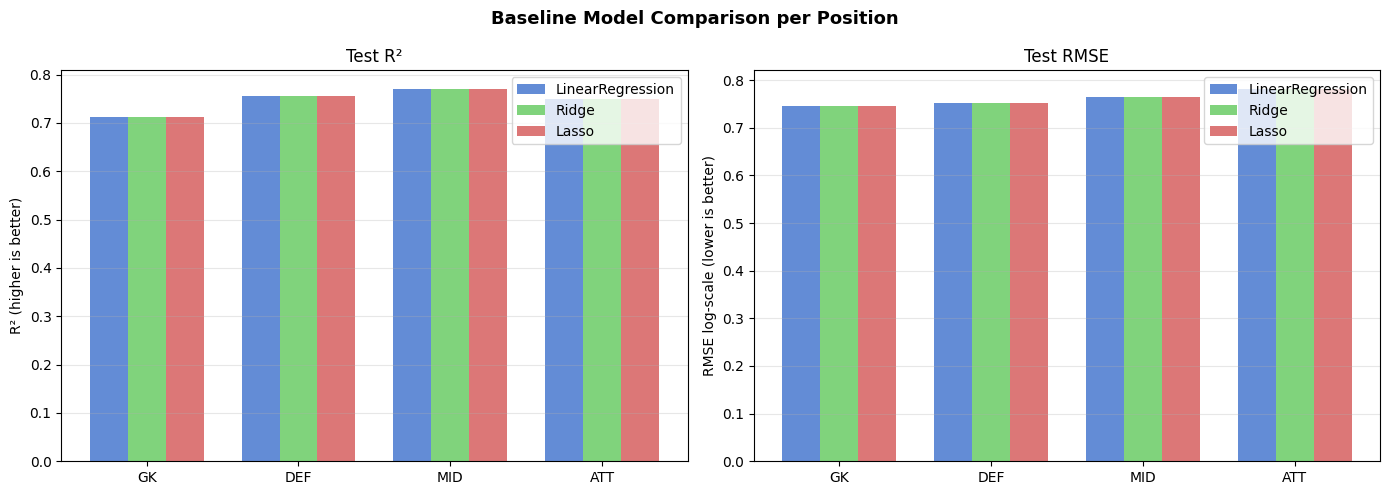

Saved figure.


In [9]:
model_names = ['LinearRegression', 'Ridge', 'Lasso']
colors      = ['#4878CF', '#6ACC65', '#D65F5F']
x           = np.arange(len(POSITIONS))
width       = 0.25

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, metric, ylabel in [
    (axes[0], 'Test R²',  'R² (higher is better)'),
    (axes[1], 'Test RMSE', 'RMSE log-scale (lower is better)'),
]:
    for i, (name, color) in enumerate(zip(model_names, colors)):
        vals = [results_df.loc[(results_df.Position==p) & (results_df.Model==name), metric].values[0]
                for p in POSITIONS]
        ax.bar(x + i*width, vals, width, label=name, color=color, alpha=0.85)

    ax.set_xticks(x + width)
    ax.set_xticklabels(POSITIONS)
    ax.set_ylabel(ylabel)
    ax.set_title(metric)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Baseline Model Comparison per Position', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '06_baseline_comparison.png')
plt.show()
print('Saved figure.')

## 6. Best Baseline per Position

Select the model with the highest **test R²** per position.

In [15]:
best_models = {}
print('Best baseline per position (by test R²):')
for pos in POSITIONS:
    best_name = max(results[pos], key=lambda n: results[pos][n]['test']['R2'])
    best_r2   = results[pos][best_name]['test']['R2']
    best_rmse = results[pos][best_name]['test']['RMSE_EUR_M']
    best_models[pos] = models[pos][best_name]
    print(f'  {pos}: {best_name:<20}  R²={best_r2:.3f}  RMSE={best_rmse:.2f}M€')

Best baseline per position (by test R²):
  GK: Lasso                 R²=0.713  RMSE=2.35M€
  DEF: LinearRegression      R²=0.756  RMSE=3.32M€
  MID: LinearRegression      R²=0.770  RMSE=6.16M€
  ATT: LinearRegression      R²=0.750  RMSE=3.72M€


## 7. Actual vs Predicted — Best Baseline (Test Set)

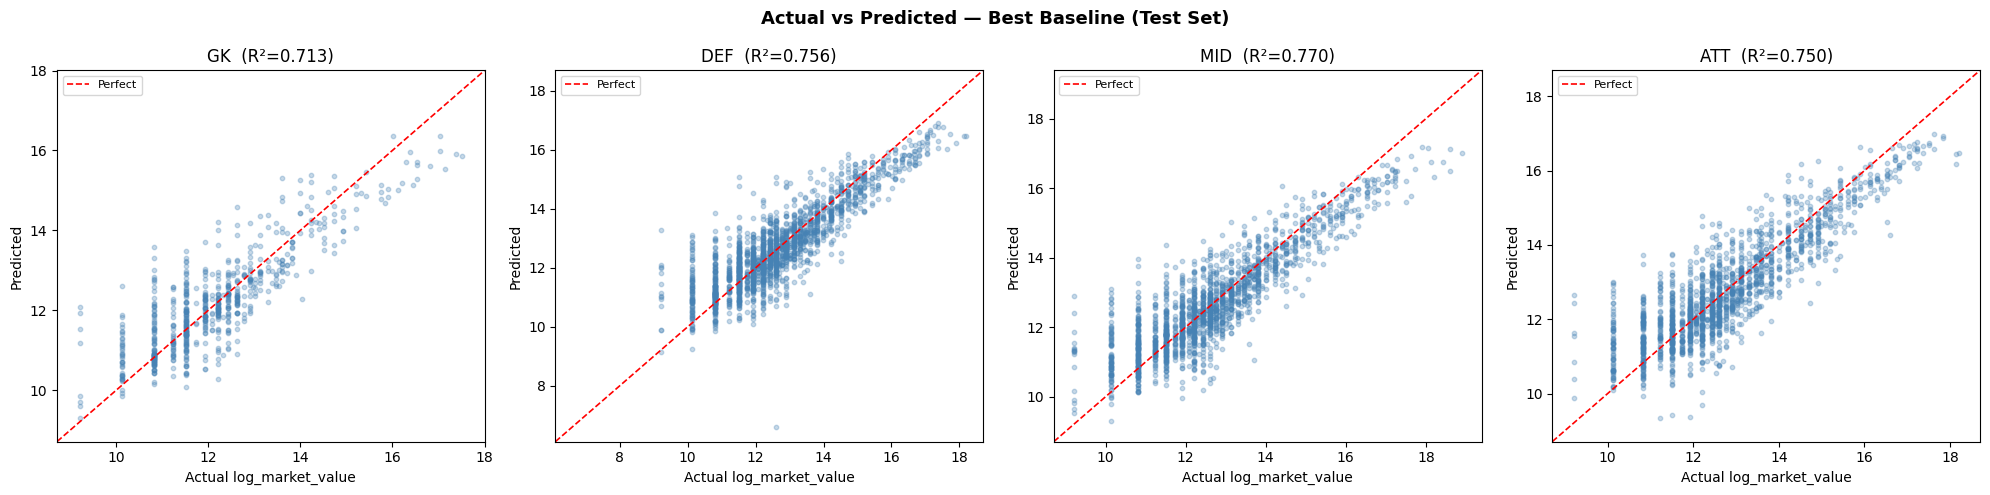

Saved figure.


In [16]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, pos in zip(axes, POSITIONS):
    X_train, X_test, y_train, y_test = data[pos]
    model   = best_models[pos]
    y_pred  = model.predict(X_test)
    r2      = results[pos][max(results[pos], key=lambda n: results[pos][n]['test']['R2'])]['test']['R2']

    ax.scatter(y_test, y_pred, alpha=0.3, s=10, color='steelblue')
    lims = [min(y_test.min(), y_pred.min()) - 0.5,
            max(y_test.max(), y_pred.max()) + 0.5]
    ax.plot(lims, lims, 'r--', linewidth=1.2, label='Perfect')
    ax.set_xlim(lims); ax.set_ylim(lims)
    ax.set_xlabel('Actual log_market_value')
    ax.set_ylabel('Predicted')
    ax.set_title(f'{pos}  (R²={r2:.3f})')
    ax.legend(fontsize=8)

plt.suptitle('Actual vs Predicted — Best Baseline (Test Set)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '06_actual_vs_predicted.png')
plt.show()
print('Saved figure.')

## 8. Residual Analysis

Residuals (actual − predicted) should be randomly scattered around zero.
Patterns indicate non-linearity that the advanced models should capture.

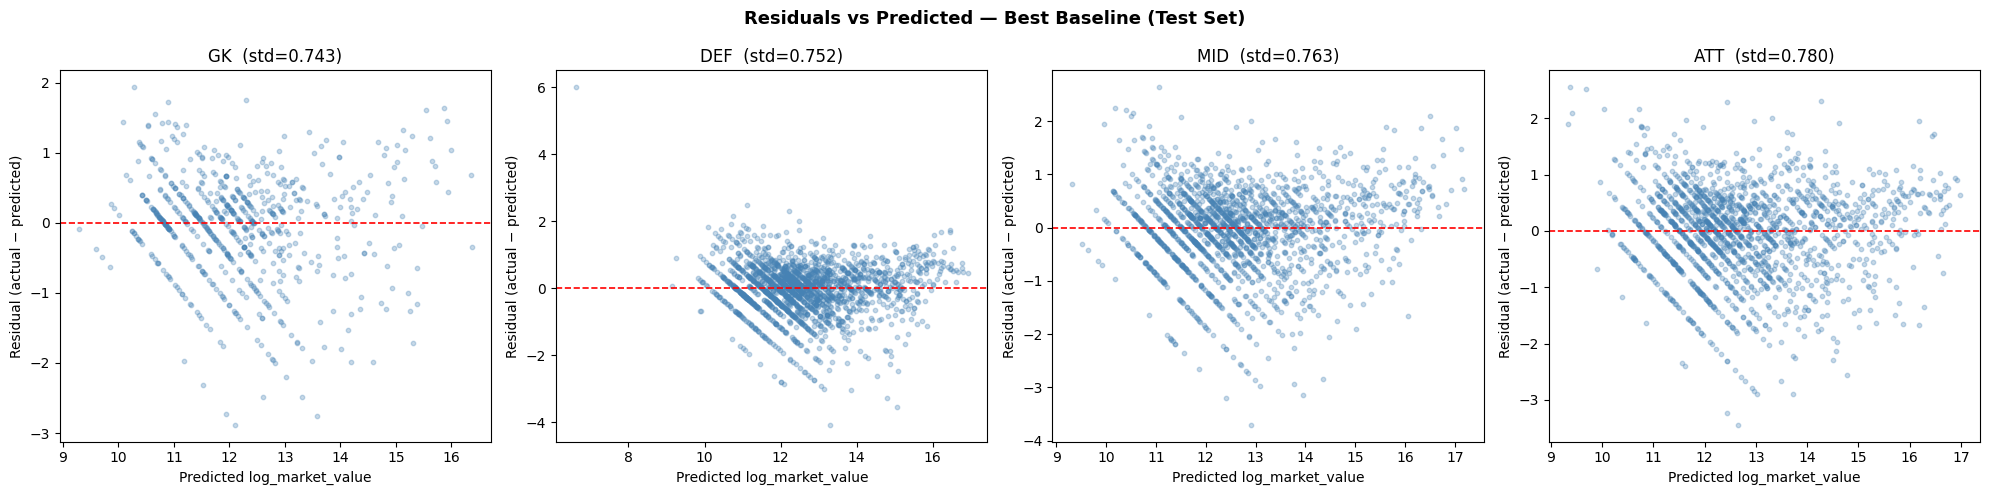

Saved figure.


In [17]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, pos in zip(axes, POSITIONS):
    X_train, X_test, y_train, y_test = data[pos]
    model     = best_models[pos]
    y_pred    = model.predict(X_test)
    residuals = y_test.values - y_pred

    ax.scatter(y_pred, residuals, alpha=0.3, s=10, color='steelblue')
    ax.axhline(0, color='red', linewidth=1.2, linestyle='--')
    ax.set_xlabel('Predicted log_market_value')
    ax.set_ylabel('Residual (actual − predicted)')
    ax.set_title(f'{pos}  (std={residuals.std():.3f})')

plt.suptitle('Residuals vs Predicted — Best Baseline (Test Set)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '06_residuals.png')
plt.show()
print('Saved figure.')

## 9. Feature Coefficients — Ridge

Ridge coefficients are stable and interpretable (unlike Lasso which zeros features).
Larger absolute coefficient = more influence on predicted value.

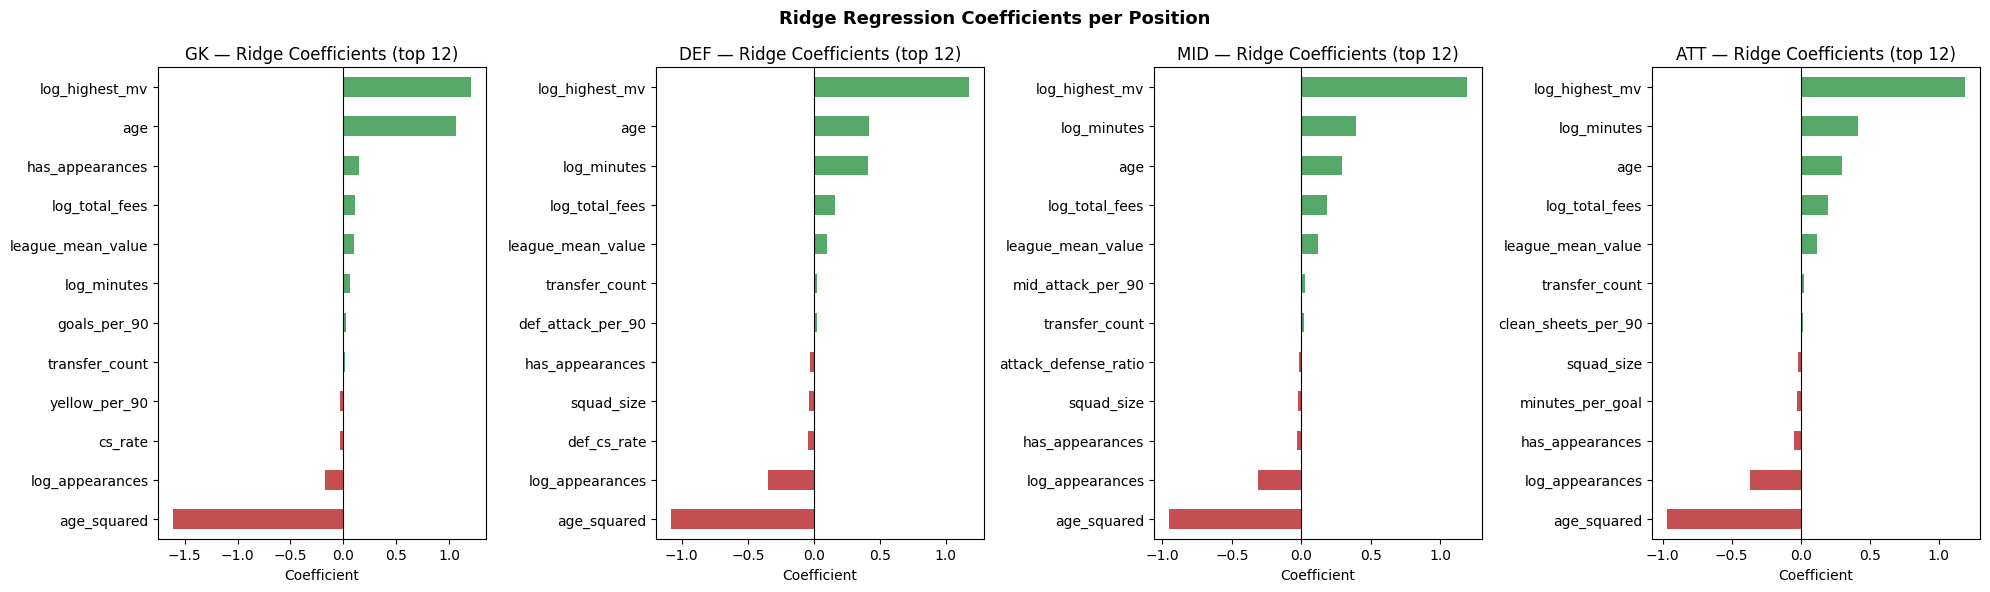

Saved figure.


In [18]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

for ax, pos in zip(axes, POSITIONS):
    ridge = models[pos]['Ridge']
    feats = FINAL_FEATURES[pos]

    coeff_df = pd.Series(ridge.coef_, index=feats).sort_values(key=abs, ascending=False).head(12)
    colors   = ['#C44E52' if v < 0 else '#55A868' for v in coeff_df.values]

    coeff_df.sort_values().plot(kind='barh', ax=ax, color=
        ['#C44E52' if v < 0 else '#55A868' for v in coeff_df.sort_values().values])
    ax.axvline(0, color='black', linewidth=0.8)
    ax.set_title(f'{pos} — Ridge Coefficients (top 12)')
    ax.set_xlabel('Coefficient')

plt.suptitle('Ridge Regression Coefficients per Position', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '06_ridge_coefficients.png')
plt.show()
print('Saved figure.')

## 10. Lasso — Features Zeroed Out

Features with coefficient = 0 are deemed uninformative by Lasso.
This informs which features to drop in the advanced models.

In [20]:
print('Features zeroed by Lasso (potential candidates to drop):')
lasso_zeroed = {}
for pos in POSITIONS:
    lasso = models[pos]['Lasso']
    feats = FINAL_FEATURES[pos]
    zeroed = [f for f, c in zip(feats, lasso.coef_) if c == 0.0]
    lasso_zeroed[pos] = zeroed
    print(f'  {pos} (α={lasso.alpha_:.4g}): {len(zeroed)}/{len(feats)} zeroed — {zeroed if zeroed else "none"}')

Features zeroed by Lasso (potential candidates to drop):
  GK (α=0.001891): 2/18 zeroed — ['log_minutes', 'assists_per_90']
  DEF (α=0.00115): 1/19 zeroed — ['contributions_per_90']
  MID (α=0.001199): 3/18 zeroed — ['assists_per_90', 'yellow_per_90', 'clean_sheets_per_90']
  ATT (α=0.001201): 1/19 zeroed — ['contributions_per_90']


## 11. Validation

In [21]:
errors = []

for pos in POSITIONS:
    X_train, X_test, y_train, y_test = data[pos]
    model = best_models[pos]

    # 1. Model fitted (has coef_)
    if not hasattr(model, 'coef_'):
        errors.append(f'{pos}: best model not fitted')
    else:
        print(f'✓  {pos}: model fitted  ({type(model).__name__})')

    # 2. Test R² > 0 (better than predicting the mean)
    r2_test = results[pos][max(results[pos], key=lambda n: results[pos][n]['test']['R2'])]['test']['R2']
    if r2_test <= 0:
        errors.append(f'{pos}: test R²={r2_test:.3f} ≤ 0 — model worse than mean')
    else:
        print(f'✓  {pos}: test R²={r2_test:.3f} > 0')

    # 3. No overfitting (train R² not much higher than test R²)
    r2_train = results[pos][max(results[pos], key=lambda n: results[pos][n]['test']['R2'])]['train']['R2']
    gap = r2_train - r2_test
    if gap > 0.15:
        errors.append(f'{pos}: large train/test gap (R² gap={gap:.3f}) — potential overfitting')
    else:
        print(f'✓  {pos}: train/test R² gap={gap:.3f} (acceptable)')

    # 4. Predictions are finite
    preds = model.predict(X_test)
    if not np.isfinite(preds).all():
        errors.append(f'{pos}: non-finite predictions')
    else:
        print(f'✓  {pos}: all predictions finite')

    print()

print('=' * 50)
if errors:
    print(f'FAILED — {len(errors)} issue(s):')
    for e in errors:
        print(f'  ✗  {e}')
else:
    print('ALL CHECKS PASSED ✓')
    print('Baseline R² targets for notebook 07:')
    for pos in POSITIONS:
        r2 = max(results[pos][n]['test']['R2'] for n in results[pos])
        print(f'  {pos}: R² > {r2:.3f}')
print('=' * 50)

✓  GK: model fitted  (LassoCV)
✓  GK: test R²=0.713 > 0
✓  GK: train/test R² gap=0.048 (acceptable)
✓  GK: all predictions finite

✓  DEF: model fitted  (LinearRegression)
✓  DEF: test R²=0.756 > 0
✓  DEF: train/test R² gap=0.018 (acceptable)
✓  DEF: all predictions finite

✓  MID: model fitted  (LinearRegression)
✓  MID: test R²=0.770 > 0
✓  MID: train/test R² gap=0.006 (acceptable)
✓  MID: all predictions finite

✓  ATT: model fitted  (LinearRegression)
✓  ATT: test R²=0.750 > 0
✓  ATT: train/test R² gap=0.023 (acceptable)
✓  ATT: all predictions finite

ALL CHECKS PASSED ✓
Baseline R² targets for notebook 07:
  GK: R² > 0.713
  DEF: R² > 0.756
  MID: R² > 0.770
  ATT: R² > 0.750


## 12. Save Outputs

In [22]:
# Best baseline models (threshold for notebook 07)
with open(MODELS_PATH + 'baseline_models.pkl', 'wb') as f:
    pickle.dump(best_models, f)

# Full results (all models × all positions)
with open(PROC_PATH + 'baseline_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f'Models saved → {os.path.abspath(MODELS_PATH)}/baseline_models.pkl')
print(f'Results saved → {os.path.abspath(PROC_PATH)}/baseline_results.json')
print()
print('Summary:')
print(results_df[['Position','Model','Test R²','Test RMSE (€M)']]
      .sort_values(['Position','Test R²'], ascending=[True, False])
      .to_string(index=False))

Models saved → /Users/giannisyfantidis/Documents/GitHub/football-player-value-predictor/models/baseline_models.pkl
Results saved → /Users/giannisyfantidis/Documents/GitHub/football-player-value-predictor/data/processed/baseline_results.json

Summary:
Position            Model  Test R²  Test RMSE (€M)
     ATT LinearRegression   0.7500           3.722
     ATT            Ridge   0.7500           3.722
     ATT            Lasso   0.7495           3.728
     DEF LinearRegression   0.7564           3.322
     DEF            Ridge   0.7564           3.323
     DEF            Lasso   0.7561           3.326
      GK            Lasso   0.7132           2.345
      GK            Ridge   0.7129           2.342
      GK LinearRegression   0.7126           2.341
     MID LinearRegression   0.7702           6.160
     MID            Ridge   0.7702           6.160
     MID            Lasso   0.7693           6.163
